In [1]:
import torchxrayvision as xrv
from preprocess import *
from dataset import *
from models import *
from evaluation import *
from explain import *

C:\Program Files\Python312\Lib\site-packages\torchxrayvision\utils.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


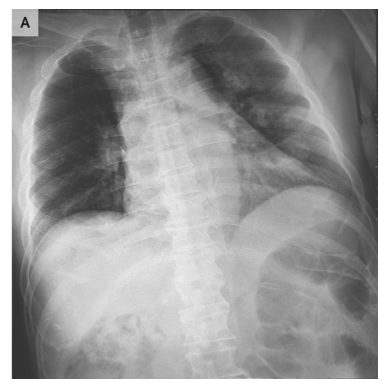

In [2]:
d = xrv.datasets.COVID19_Dataset(imgpath = "data/images/", csvpath = "data/csv/metadata.csv")
BATCH_SIZE = 16

unsampled_d = preprocess(d, resample = False)
show_image(unsampled_d, 0, processed = True)
sample_img_pos = d[0]['img'][0]
sample_input = tensorize_image(sample_img_pos).unsqueeze(0)

In [3]:
unsampled_train_dataset = Covid19DataSet('train', unsampled_d)
unsampled_validation_dataset = Covid19DataSet('val', unsampled_d)
unsampled_test_dataset = Covid19DataSet('test', unsampled_d)
unsampled_train_loader = DataLoader(dataset = unsampled_train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 0)
unsampled_validation_loader = DataLoader(dataset = unsampled_validation_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = 0)
unsampled_test_loader = DataLoader(dataset = unsampled_test_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = 0)


In [4]:
resnet_v_us = MyResNet18()
resnet_us, resnet_stats_us = train_model(resnet_v_us, unsampled_train_loader, unsampled_validation_loader, epochs = 10)

Training model
Epoch [1/10] |Training Loss: 0.0461 | Validation Loss: 0.0399 | Training Acc: 58.57%
Epoch [2/10] |Training Loss: 0.0408 | Validation Loss: 0.0384 | Training Acc: 64.80%
Epoch [3/10] |Training Loss: 0.0395 | Validation Loss: 0.0398 | Training Acc: 67.29%
Epoch [4/10] |Training Loss: 0.0376 | Validation Loss: 0.0402 | Training Acc: 70.09%
Epoch [5/10] |Training Loss: 0.0363 | Validation Loss: 0.0396 | Training Acc: 71.03%
Epoch [6/10] |Training Loss: 0.0356 | Validation Loss: 0.0385 | Training Acc: 72.27%
Epoch [7/10] |Training Loss: 0.0354 | Validation Loss: 0.0356 | Training Acc: 76.32%
Epoch [8/10] |Training Loss: 0.0368 | Validation Loss: 0.0349 | Training Acc: 73.21%
Epoch [9/10] |Training Loss: 0.0331 | Validation Loss: 0.0339 | Training Acc: 76.95%
Epoch [10/10] |Training Loss: 0.0337 | Validation Loss: 0.0345 | Training Acc: 76.95%
Training completed in 3mins 25.69s
Best Loss: 0.0670 | Training Accuracy: 77%


In [10]:
def get_metrics2(model, test_loader):

    model.eval()

    with torch.no_grad():
        tp = tn = fp = fn = t = f = n = 0
        for j, (images, labels) in enumerate(test_loader):

            outputs = model(images)
            probs = torch.sigmoid(outputs)
            y_preds = (torch.sigmoid(outputs) >= 0.5).float()
            
            k = y_preds.size(dim = 0)
            n += k

            for i in range(k):
                pred_val, label_val = y_preds[i].item(), labels[i].item()
                tp += (pred_val == label_val == 1)
                tn += (pred_val == label_val == 0)
                fp += (pred_val == 1 and label_val == 0)
                fn += (pred_val == 0 and label_val == 1)
                f += (pred_val == 0)
                t += (pred_val == 1)

    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1 = (2*tp) / (2*tp + fp + fn) if (tp + fp + fn) > 0 else 0
    print(f"Precision: {prec:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | Positives: {t} | Negatives: {f} | Total: {n}")

    return recall, prec, f1, t, f, n
    
def plot_loss2(epochs, train_loss, val_loss, title):
    plt.figure(figsize=(8, 6))
    plt.plot([i+1 for i in range(epochs)], train_loss, label='training', linestyle='-', color='blue', marker='o')
    plt.plot([i+1 for i in range(epochs)], val_loss, label='validation', linestyle='--', color='red', marker='s')
    
    plt.xticks(ticks = range(1, epochs+1, 1))
    plt.yscale('log')

    plt.xlabel('Epochs')
    plt.ylabel('BCE loss (log scale)')
    plt.title(f'Loss (BCE) with each epoch ({title})')
    plt.legend()
    plt.show()

In [13]:
rn_t_loss_us, rn_t_acc_us, rn_v_loss_us, rn_v_acc_us, cn_time_us = resnet_stats_us
rn_prec_us, rn_rec_us, rn_f1_us, *rn_rest_us = get_metrics2(resnet_us, unsampled_test_loader)

Precision: 0.8333 | Recall: 0.9028 | F1: 0.8667 | Positives: 78 | Negatives: 29 | Total: 107


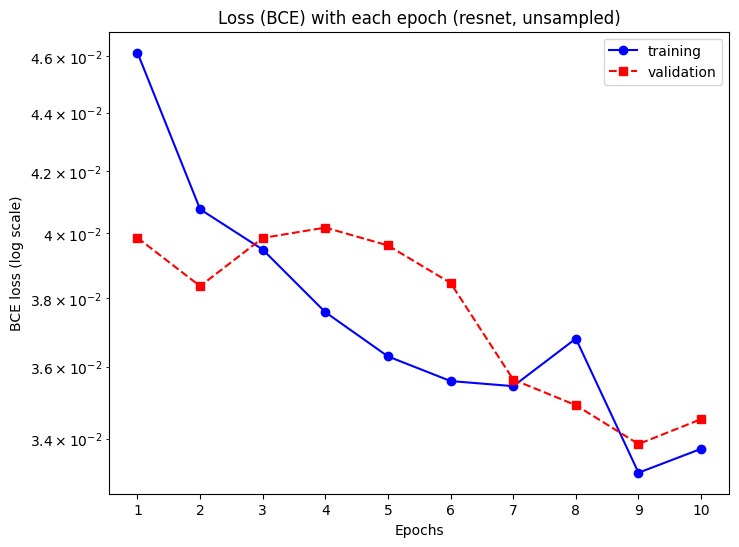

In [14]:
plot_loss2(10, rn_t_loss_us, rn_v_loss_us, 'resnet, unsampled')

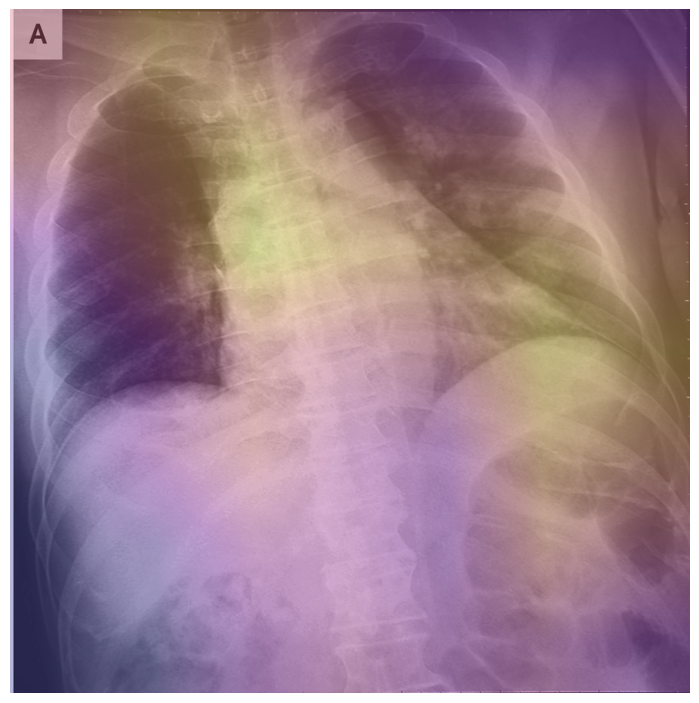

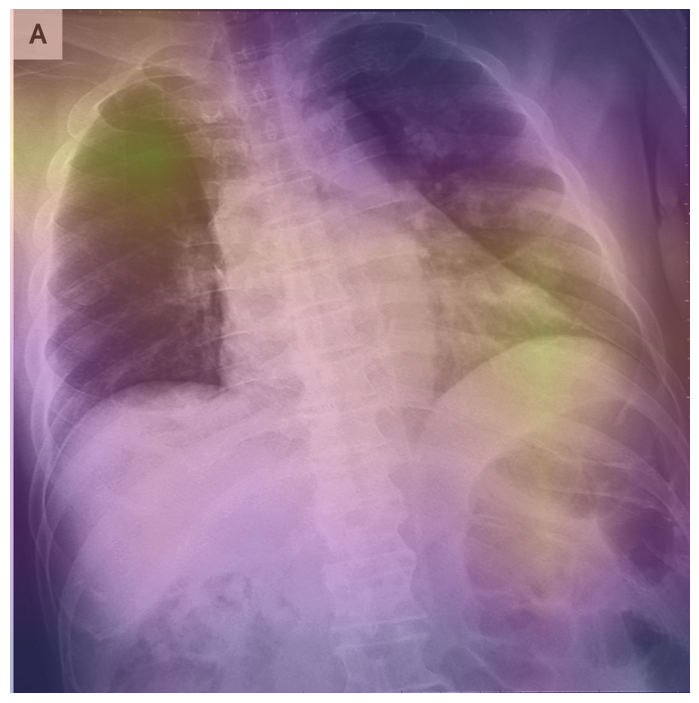

In [6]:
for param in resnet_us.parameters():
    param.requires_grad = True
visualize_heatmaps(resnet_us, sample_img_pos, sample_input)

In [ ]:
visualize_heatmaps2(resnet_us, sample_img, sample_input)

In [ ]:
neg = find_negative(d, 4)
sample_img_neg = d[neg]['img'][0]
sample_input_neg = tensorize_image(sample_img_neg).unsqueeze(0)